In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from Module.ICSS import *

warnings.filterwarnings('ignore')

In [2]:
def load_data(file_path: str, sat_no: str, start_date: str, end_date: str, created_time: bool):
    '''
    :param file_path: 위성데이터가 있는 폴더경로
    :param sat_no: 위성번호
    :param start_date: 불러올 데이터의 시작날짜
    :param end_date: 불러올 데이터의 종료날짜
    :param created_time: created time인지 epoch time인지 여부
    :return: 시간 단위로 추출된 통계량 DataFrame
    '''
    if created_time:
        info_df = pd.read_csv(f'{file_path}/{sat_no}_created.csv')
    if not created_time:
        info_df = pd.read_csv(f'{file_path}/{sat_no}_epoch.csv')
    info_df = info_df.set_index('Time').sort_index()
    info_df.index = pd.to_datetime(info_df.index)
    info_df = info_df[info_df.index > start_date].copy()
    info_df = info_df[info_df.index <= end_date].copy()
    hour_df = info_df[::60].copy()
    hour_df['Semi-Major Axis(km)'] = (hour_df['Perigee'] + hour_df['Apogee']) / 2
    hour_df['Semi-Major Axis(km)'] = hour_df['Semi-Major Axis(km)'] / 100
    return hour_df

In [3]:
def plot_graph(hour_df: pd.DataFrame, KT_maneuvering_lst: list, XY_Maneuvering: bool, start_date: str, end_date: str):
    '''
    :param hour_df: 시간 단위로 추출된 통계량 DataFrame
    :param XY_Maneuvering: XY maneuvering 인지 Z maneuvering 인지 여부
    :param start_date: 그래프의 시작날짜
    :param end_date: 그래프의 종료날짜 
    :return: 그래프 출력
    '''

    # Maneuvering 별 이상치탐지 DataFrame 생성.
    ol_all_infos = []
    if XY_Maneuvering:
        col_lst = ['Eccentricity', 'Semi-Major Axis(km)']
        for col in col_lst:
            diff_value = np.log(hour_df[col]).diff().fillna(0).values
            for level in [95, 99]:
                for window in [24 * 5, 24 * 10]:
                    temp = [col, level, window, 'ON']
                    print(f'window : {window}, level : {level}')
                    temp.extend(ol_detect(hour_df, diff_value, window, level))
                    ol_all_infos.append(temp)

    if not XY_Maneuvering:
        col_lst = ['Inclination(deg)', 'RAAN(deg)']
        for col in col_lst:
            diff_value = np.log(hour_df[col]).diff().fillna(0).values
            for level in [95, 99]:
                for window in [24 * 5, 24 * 10]:
                    temp = [col, level, window, 'ON']
                    print(f'window : {window}, level : {level}')
                    temp.extend(ol_detect(hour_df, diff_value, window, level))
                    ol_all_infos.append(temp)

    temp_df = pd.DataFrame(ol_all_infos).astype('str')

    # 이상치탐지 DataFrame으로 그래프 출력
    for i in range(4):
        # 두 가지 통계량에서 모두 탐지된 이상치만 True 이상치로 분류
        first_lst = temp_df.iloc[i][4:]
        second_lst = temp_df.iloc[i + 4][4:]
        co_ol_lst = [pd.to_datetime(ol) for ol in list(set(first_lst) & set(second_lst)) if ol != 'NaT']
        co_ol_lst.sort()
        print(list(temp_df.iloc[i][1:4])[0] + '% threshold, ' + list(temp_df.iloc[i][1:4])[1] + 'hours')
        # print(co_ol_lst)

        # 첫번째 통계량의 그래프를 출력
        fig, ax1 = plt.subplots(figsize=(10, 1.5), dpi=400)
        ax1.plot(hour_df[temp_df.iloc[i][0]][(pd.to_datetime(start_date) <= hour_df[temp_df.iloc[i][0]].index) & (
                hour_df[temp_df.iloc[i][0]].index <= pd.to_datetime(end_date))],
                 color=(40 / 255, 217 / 255, 9 / 255), label=temp_df.iloc[i][0])
        ax1.set_xlabel('Date')
        ax1.set_ylabel(temp_df.iloc[i][0], fontsize=9, color=(40 / 255, 217 / 255, 9 / 255))
        ax1.tick_params(axis='y', colors=(40 / 255, 217 / 255, 9 / 255))

        # 두번째 통계량의 그래프를 출력
        ax2 = ax1.twinx()
        ax2.plot(
            hour_df[temp_df.iloc[i + 4][0]][(pd.to_datetime(start_date) <= hour_df[temp_df.iloc[i + 4][0]].index) & (
                    hour_df[temp_df.iloc[i + 4][0]].index <= pd.to_datetime(end_date))], color=(0, 0, 1),
            label=temp_df.iloc[i + 4][0])
        ax2.set_ylabel(temp_df.iloc[i + 4][0], fontsize=9, color=(0, 0, 1))
        ax2.tick_params(axis='y', colors=(0, 0, 1))
        formatter = ticker.ScalarFormatter(useOffset=False)
        ax2.yaxis.set_major_formatter(formatter)

        # 이상치를 위 그래프 위에 표시
        for point in co_ol_lst:
            if (pd.to_datetime(start_date) <= point) & (point <= pd.to_datetime(end_date)):
                plt.axvline(point, color=(1, 0, 0), linewidth=1, linestyle='--', label="Detected Maneuver using TLE")  #
                ax1.scatter(point, hour_df[col_lst[0]].loc[point], color=(1, 0, 0), s=10, zorder=5)
                ax2.scatter(point, hour_df[col_lst[1]].loc[point], color=(1, 0, 0), s=10, zorder=5)

        # KT sat의 실제 maneuvering을 위 그래프에 표시
        for time in KT_maneuvering_lst:
            time = pd.to_datetime(time)
            if (pd.to_datetime(start_date) <= time) & (time <= pd.to_datetime(end_date)):
                ax2.axvline(time, color=(0, 0, 0), linewidth=1, linestyle='-', label="KT Sat's Maneuver")

                start_time = time - pd.Timedelta(days=0.25)
                end_time = time + pd.Timedelta(days=0.25)

                triangle1 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                             (mdates.date2num(time),
                                              ax2.get_ylim()[0] + (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                                             (mdates.date2num(end_time), ax2.get_ylim()[0])),
                                            facecolor='black', edgecolor='black', linewidth=1, linestyle='-', zorder=10)
                ax2.add_patch(triangle1)

                triangle2 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[1]),
                                             (mdates.date2num(time),
                                              ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                                             (mdates.date2num(end_time), ax2.get_ylim()[1])),
                                            facecolor='black', edgecolor='black', linewidth=1, linestyle='-', zorder=10)
                ax2.add_patch(triangle2)

        # plot의 범례 표시
        plt.xlabel('Date')
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.4))
        plt.show()

In [4]:
kt_data_XY = [
    "2023-09-22 7:00:00",
    "2023-09-27 10:00:00",
    "2023-10-06 8:00:00",
    "2023-10-13 9:30:00",
    "2023-10-20 5:00:00",
    "2023-10-27 8:00:00"]

kt_data_Z = [
    "2023-09-25 10:25:31",
    "2023-10-10 9:26:06",
    "2023-10-24 8:30:39"]

In [5]:
created_hour_df = load_data('../../Database', '42984', '2022-12-31 23:59:59', '2024-08-01 00:00:00', True)
epoch_hour_df = load_data('../../Database', '42984', '2022-12-31 23:59:59', '2024-08-01 00:00:00', False)

# Real time KT sat XY Manuevering

window : 120, level : 95


100%|██████████| 13754/13754 [00:03<00:00, 4176.19it/s]


window : 240, level : 95


100%|██████████| 13634/13634 [00:03<00:00, 4199.78it/s]


window : 120, level : 99


100%|██████████| 13754/13754 [00:03<00:00, 4182.26it/s]


window : 240, level : 99


100%|██████████| 13634/13634 [00:03<00:00, 4252.57it/s]


window : 120, level : 95


100%|██████████| 13754/13754 [00:03<00:00, 4168.16it/s]


window : 240, level : 95


100%|██████████| 13634/13634 [00:03<00:00, 4179.78it/s]


window : 120, level : 99


100%|██████████| 13754/13754 [00:03<00:00, 4194.62it/s]


window : 240, level : 99


100%|██████████| 13634/13634 [00:03<00:00, 4194.21it/s]


95% threshold, 120hours


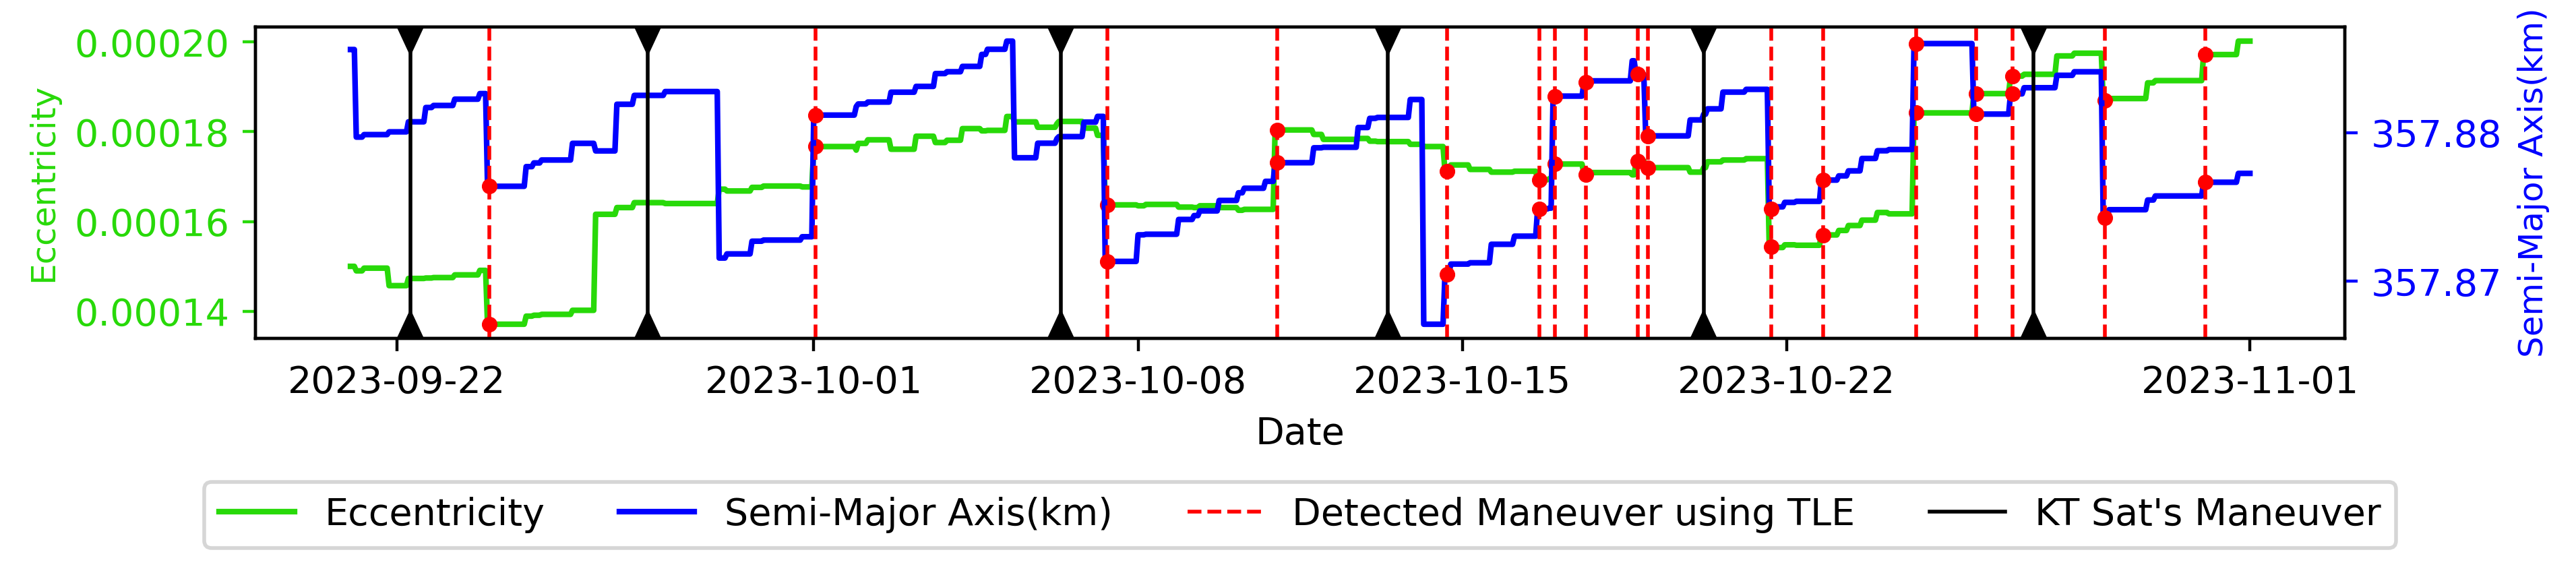

95% threshold, 240hours


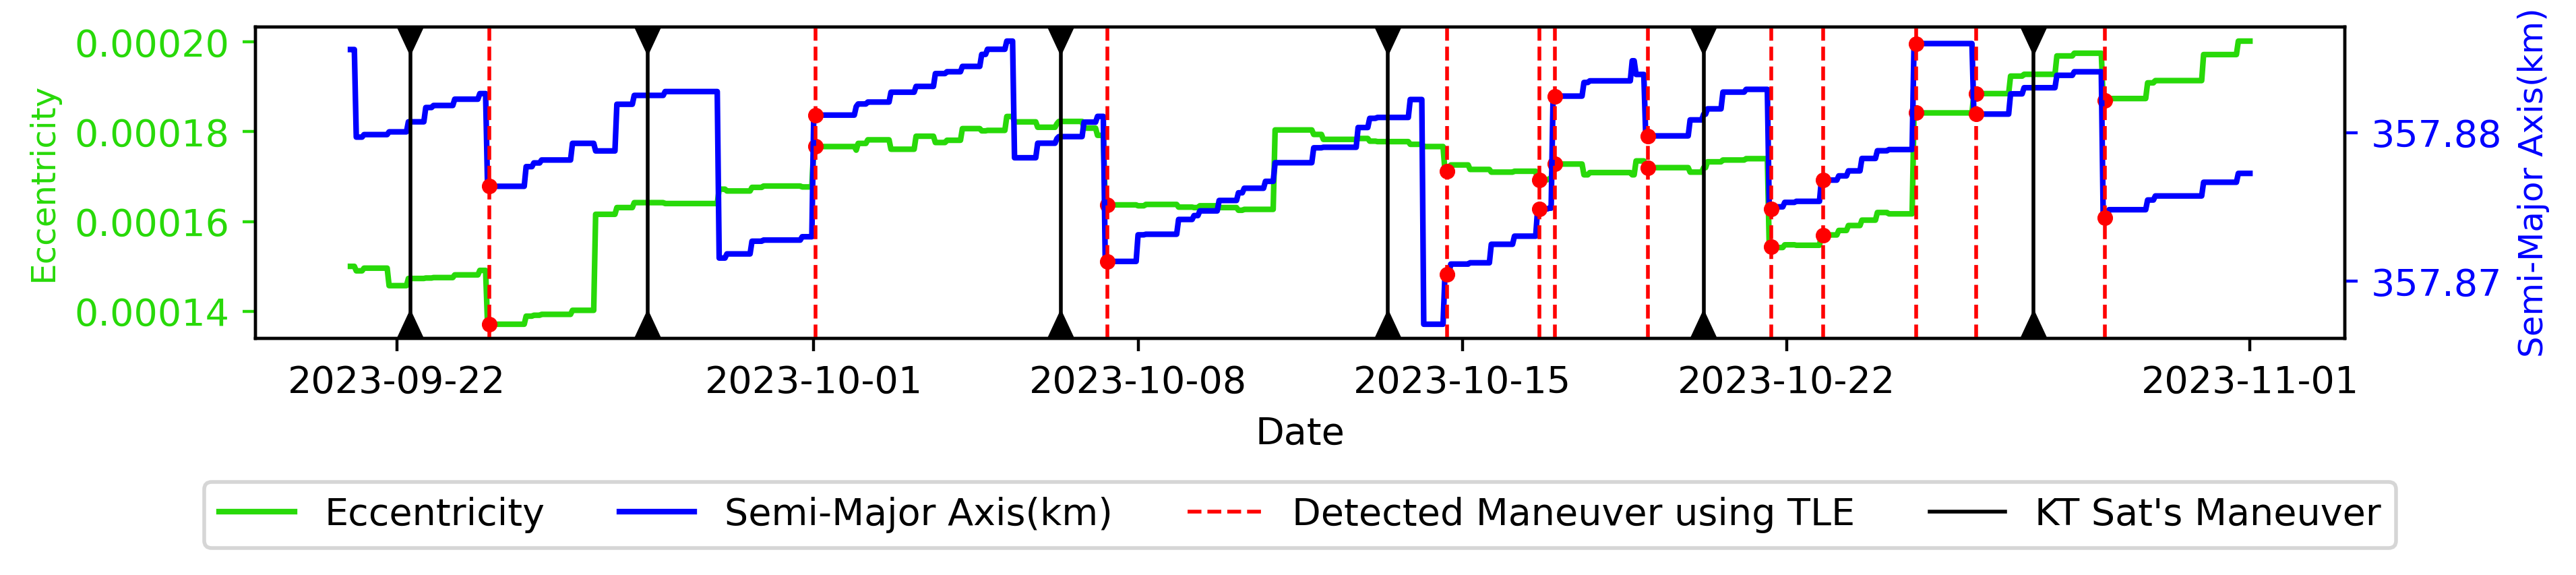

99% threshold, 120hours


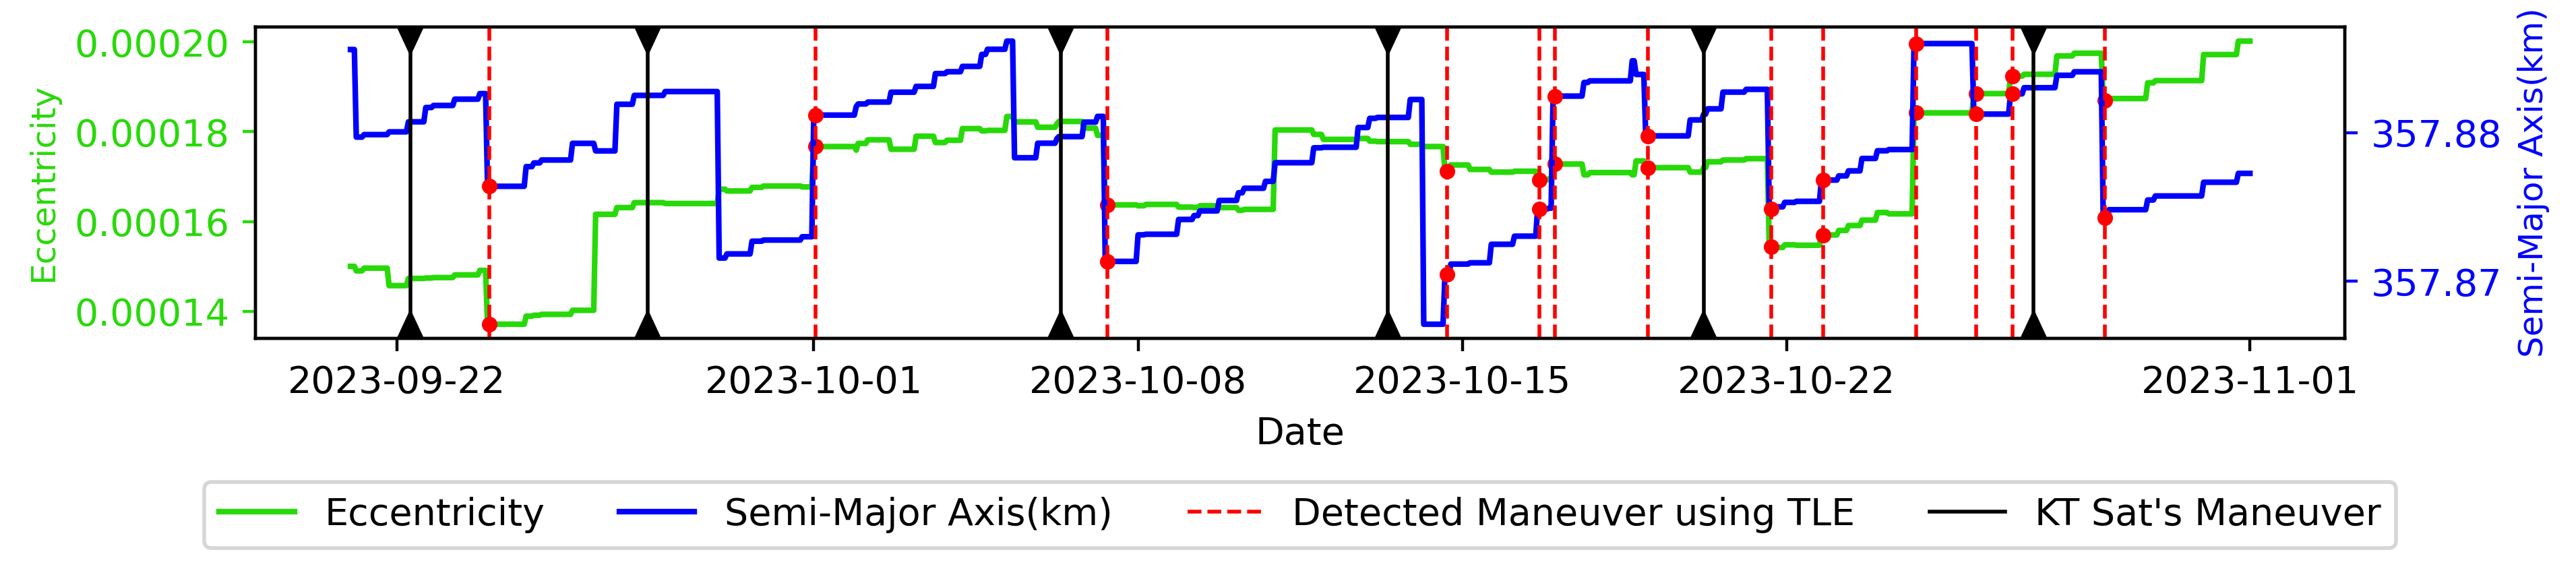

99% threshold, 240hours


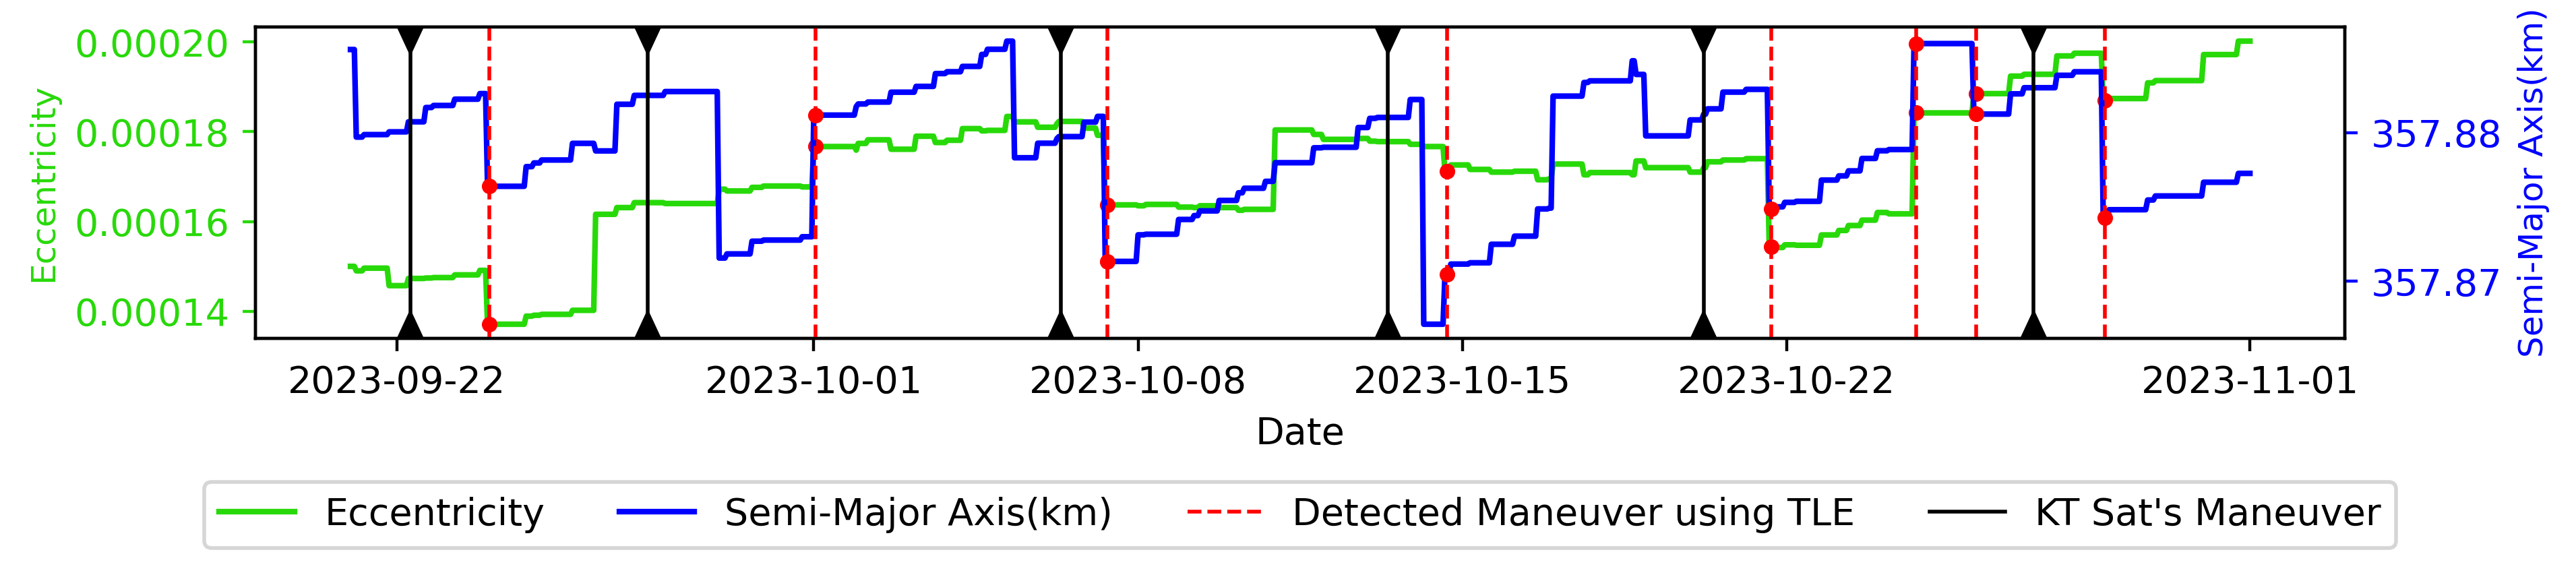

In [6]:
plot_graph(created_hour_df, kt_data_XY, True, '2023-09-21', '2023-11-01')

# Epoch time KT sat XY Manuevering

window : 120, level : 95


100%|██████████| 13753/13753 [00:03<00:00, 4113.34it/s]


window : 240, level : 95


100%|██████████| 13633/13633 [00:03<00:00, 4146.89it/s]


window : 120, level : 99


100%|██████████| 13753/13753 [00:03<00:00, 4143.19it/s]


window : 240, level : 99


100%|██████████| 13633/13633 [00:03<00:00, 4186.26it/s]


window : 120, level : 95


100%|██████████| 13753/13753 [00:03<00:00, 4109.18it/s]


window : 240, level : 95


100%|██████████| 13633/13633 [00:03<00:00, 4099.44it/s]


window : 120, level : 99


100%|██████████| 13753/13753 [00:03<00:00, 4157.71it/s]


window : 240, level : 99


100%|██████████| 13633/13633 [00:03<00:00, 4172.61it/s]


95% threshold, 120hours


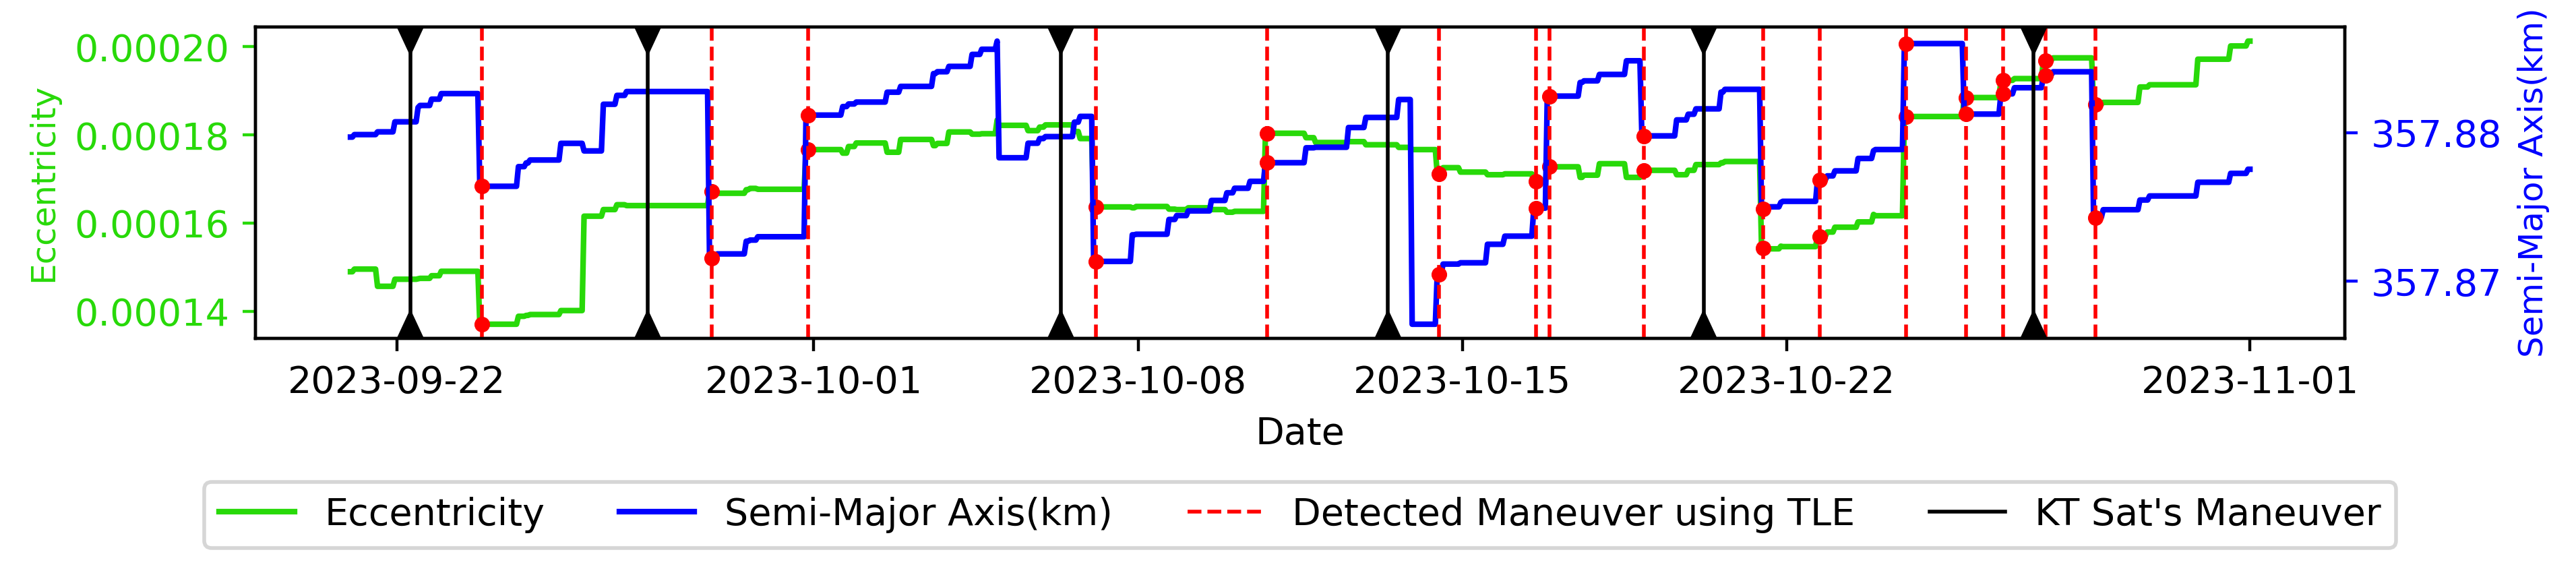

95% threshold, 240hours


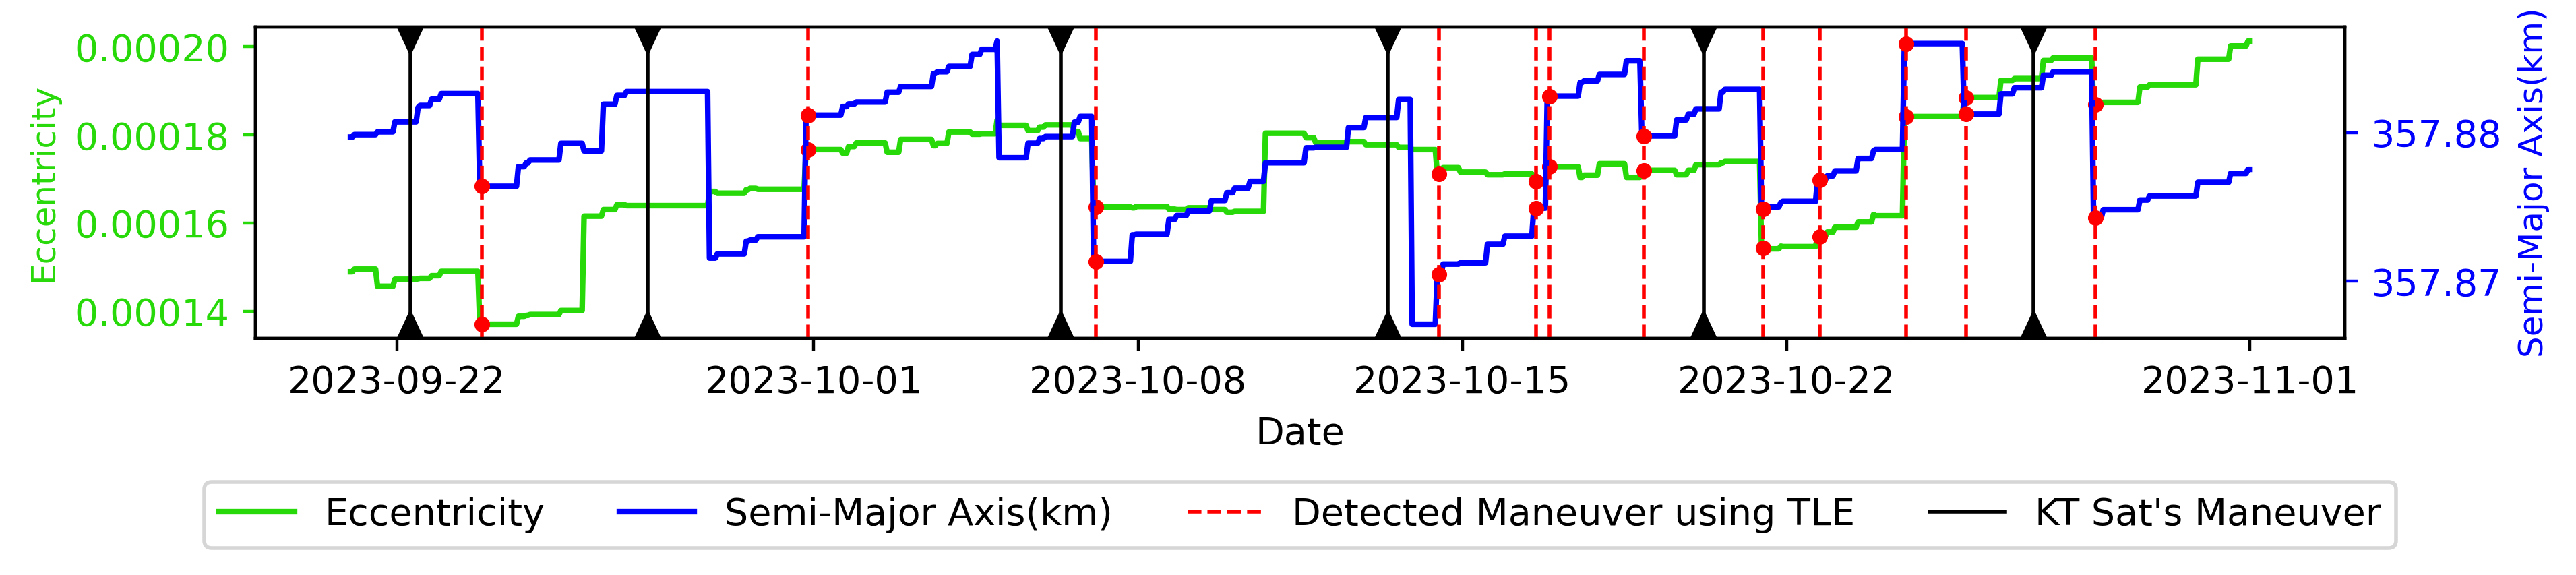

99% threshold, 120hours


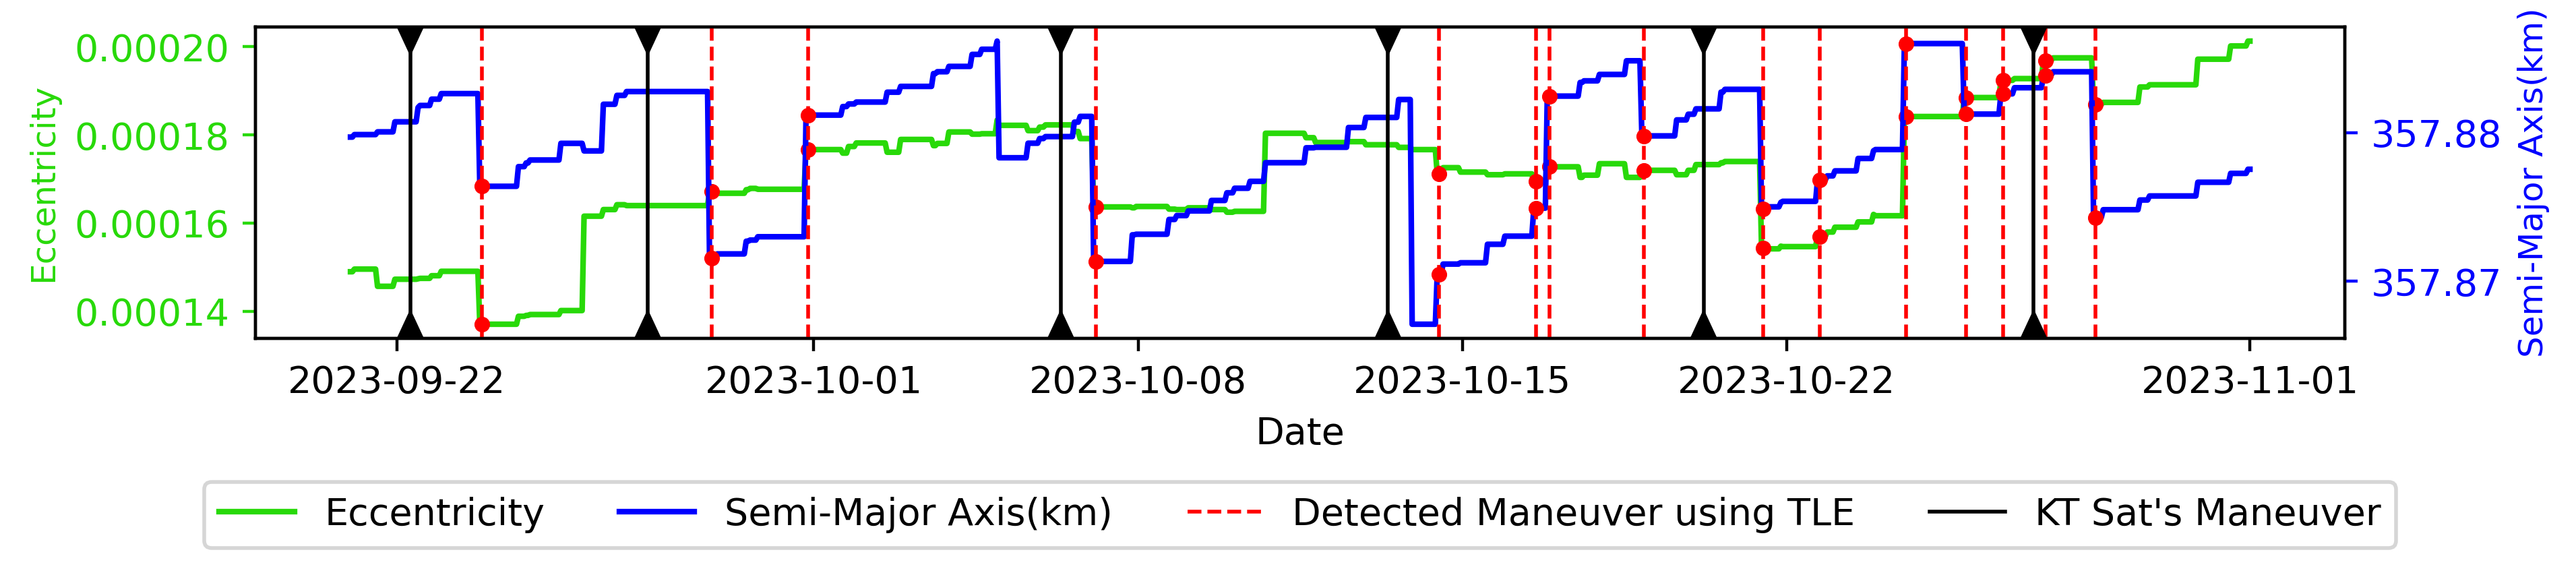

99% threshold, 240hours


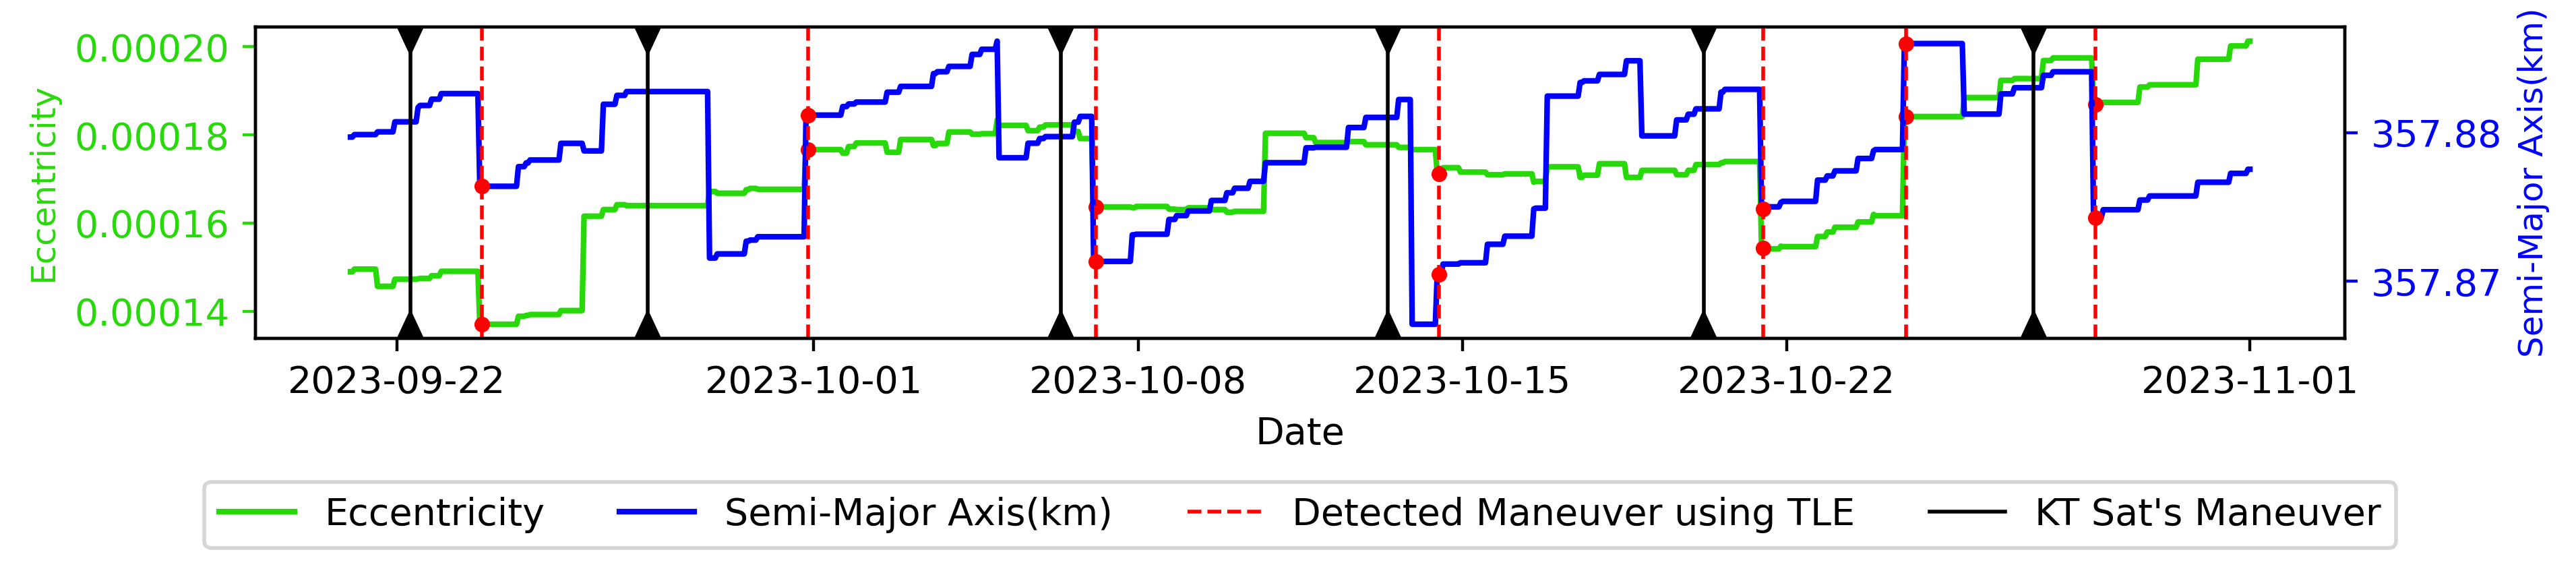

In [7]:
plot_graph(epoch_hour_df, kt_data_XY, True, '2023-09-21', '2023-11-01')

# Real time KT sat Z Manuevering

window : 120, level : 95


100%|██████████| 13754/13754 [00:04<00:00, 3412.67it/s]


window : 240, level : 95


100%|██████████| 13634/13634 [00:03<00:00, 3684.05it/s]


window : 120, level : 99


100%|██████████| 13754/13754 [00:03<00:00, 3620.68it/s]


window : 240, level : 99


100%|██████████| 13634/13634 [00:03<00:00, 3710.43it/s]


window : 120, level : 95


100%|██████████| 13754/13754 [00:04<00:00, 3084.06it/s]


window : 240, level : 95


100%|██████████| 13634/13634 [00:05<00:00, 2319.12it/s]


window : 120, level : 99


100%|██████████| 13754/13754 [00:04<00:00, 2808.37it/s]


window : 240, level : 99


100%|██████████| 13634/13634 [00:04<00:00, 3264.89it/s]


95% threshold, 120hours


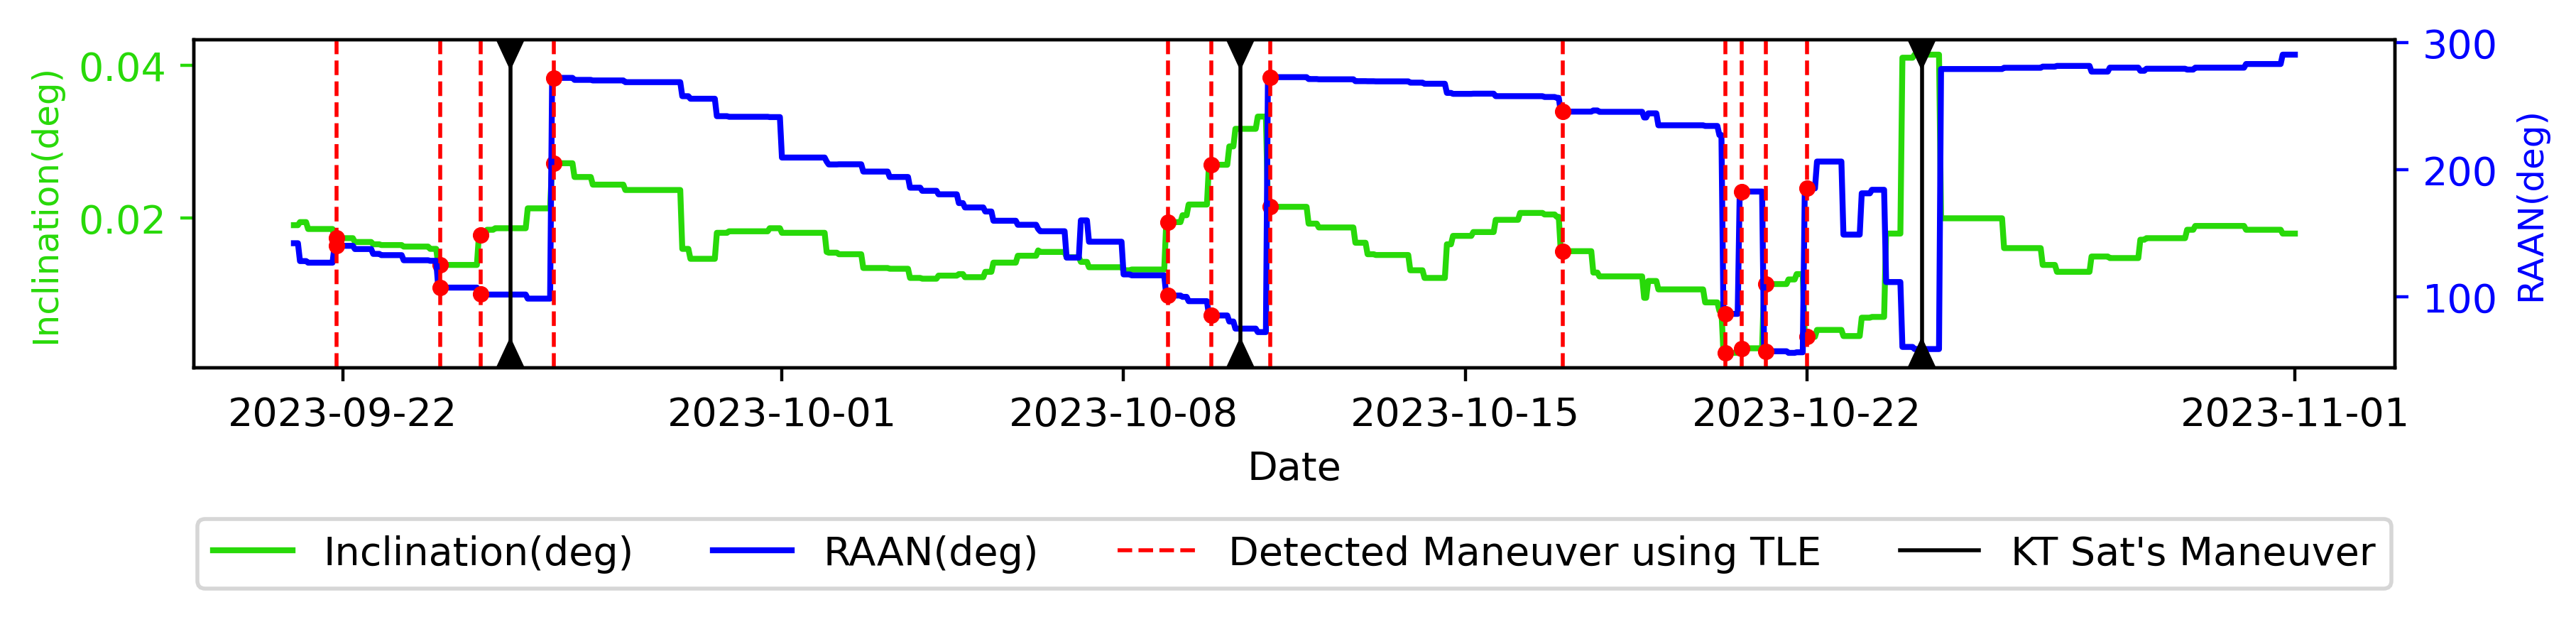

95% threshold, 240hours


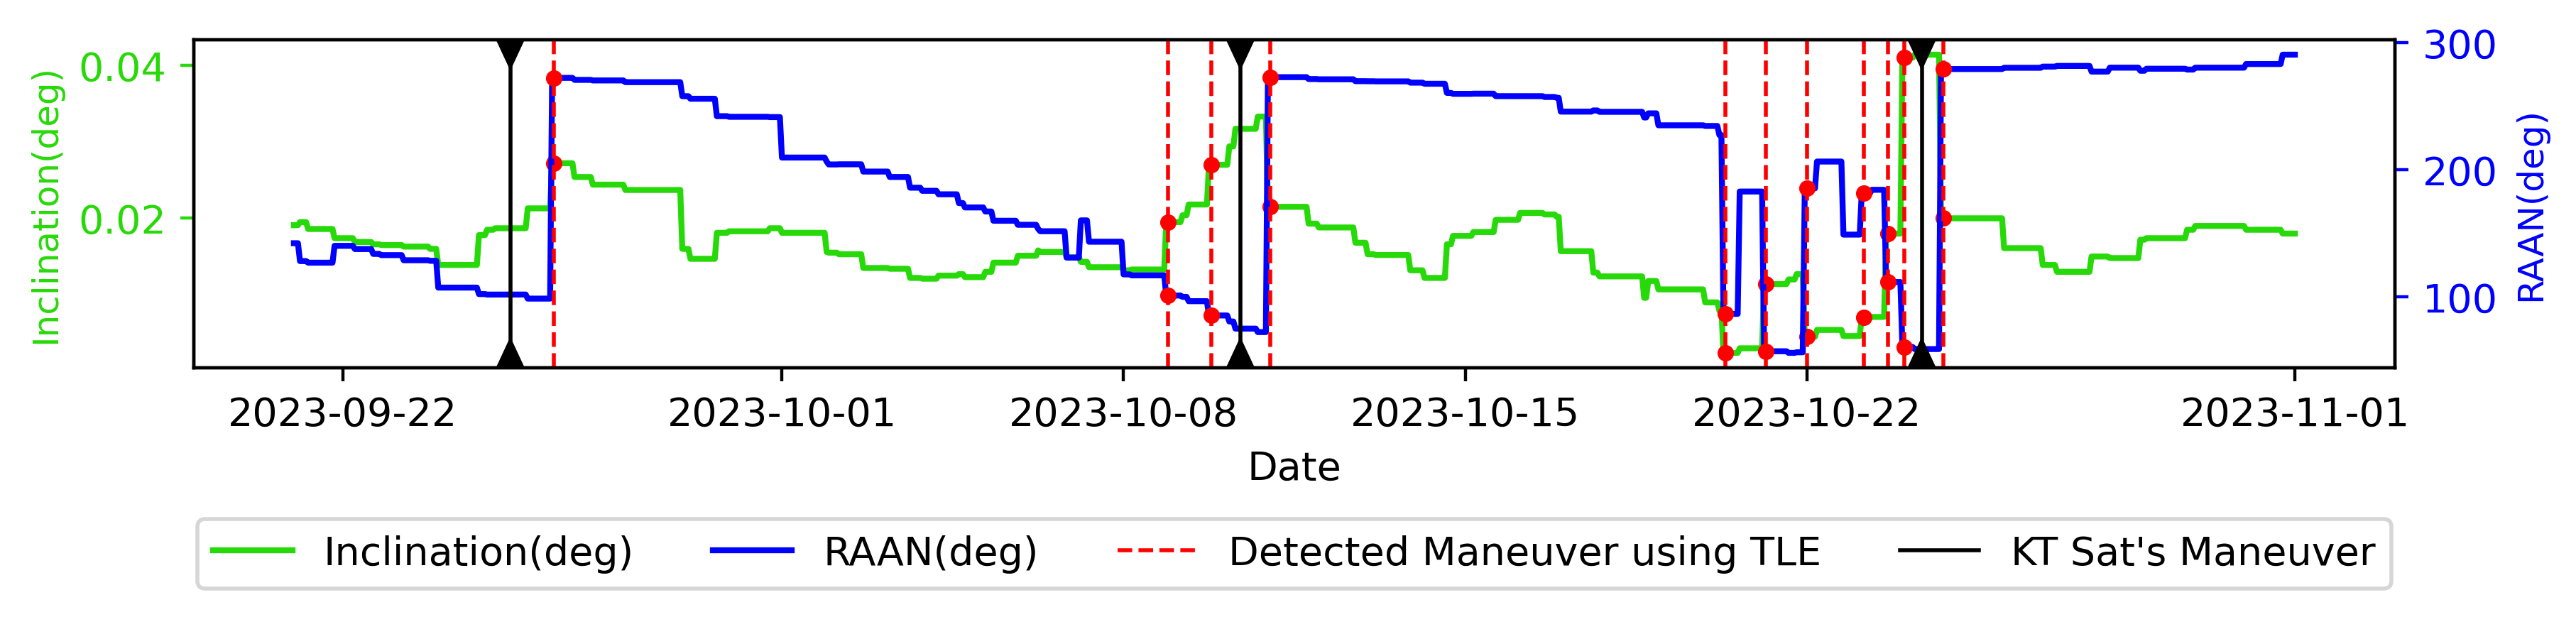

99% threshold, 120hours


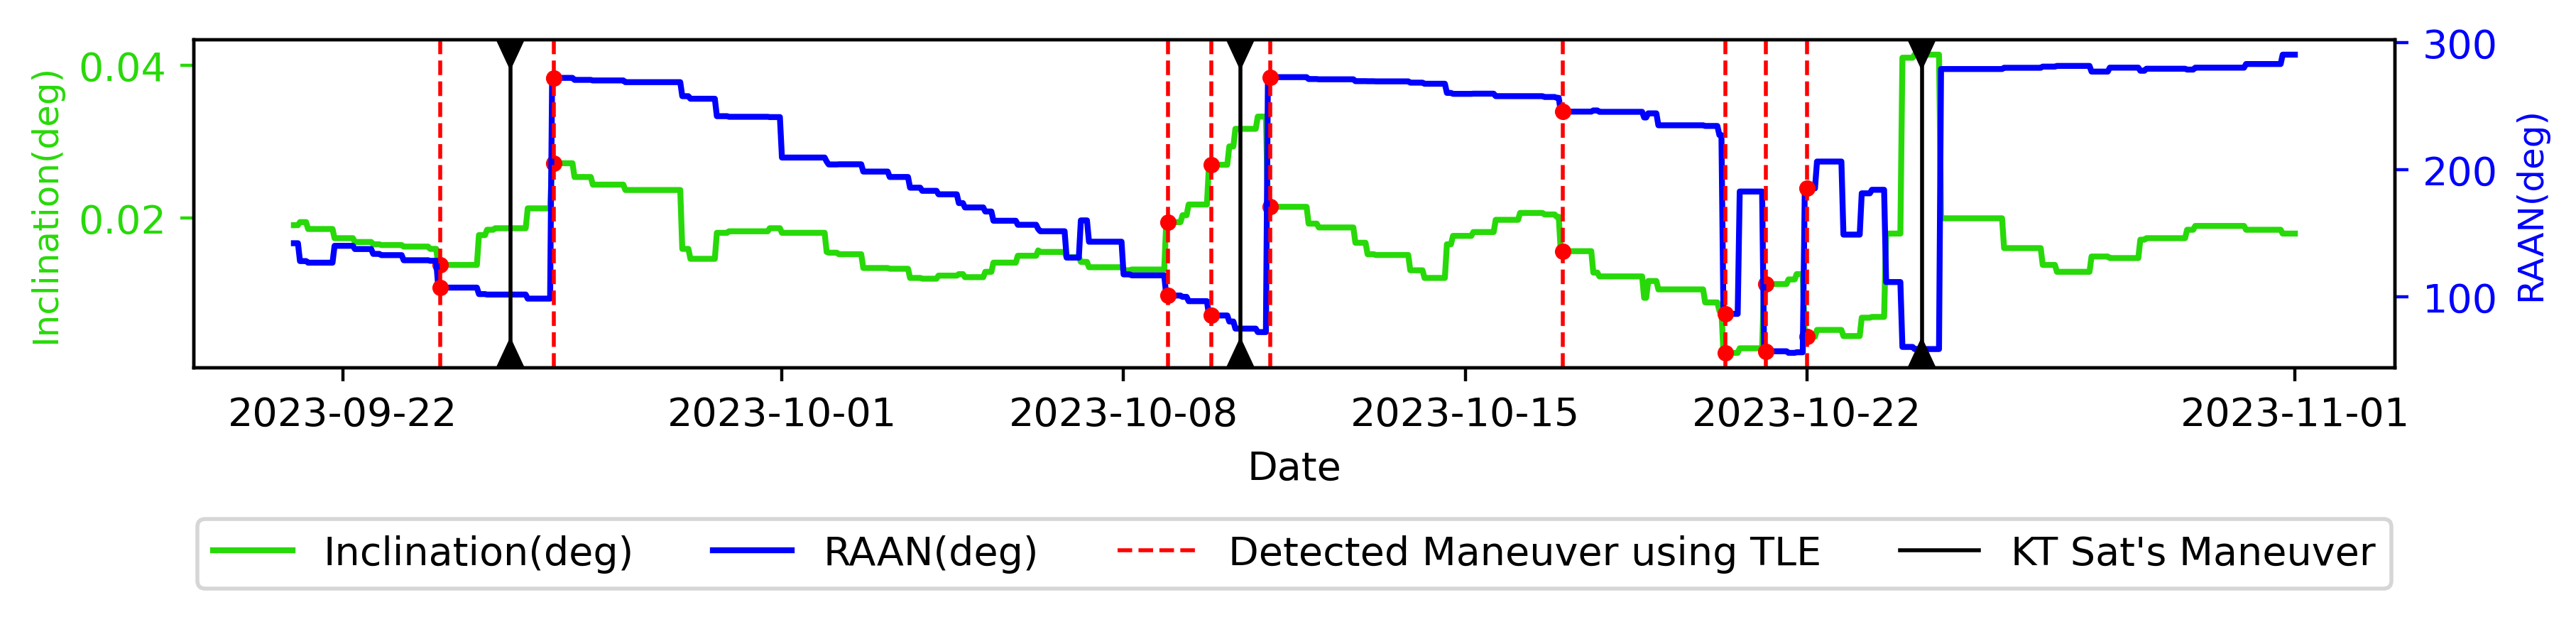

99% threshold, 240hours


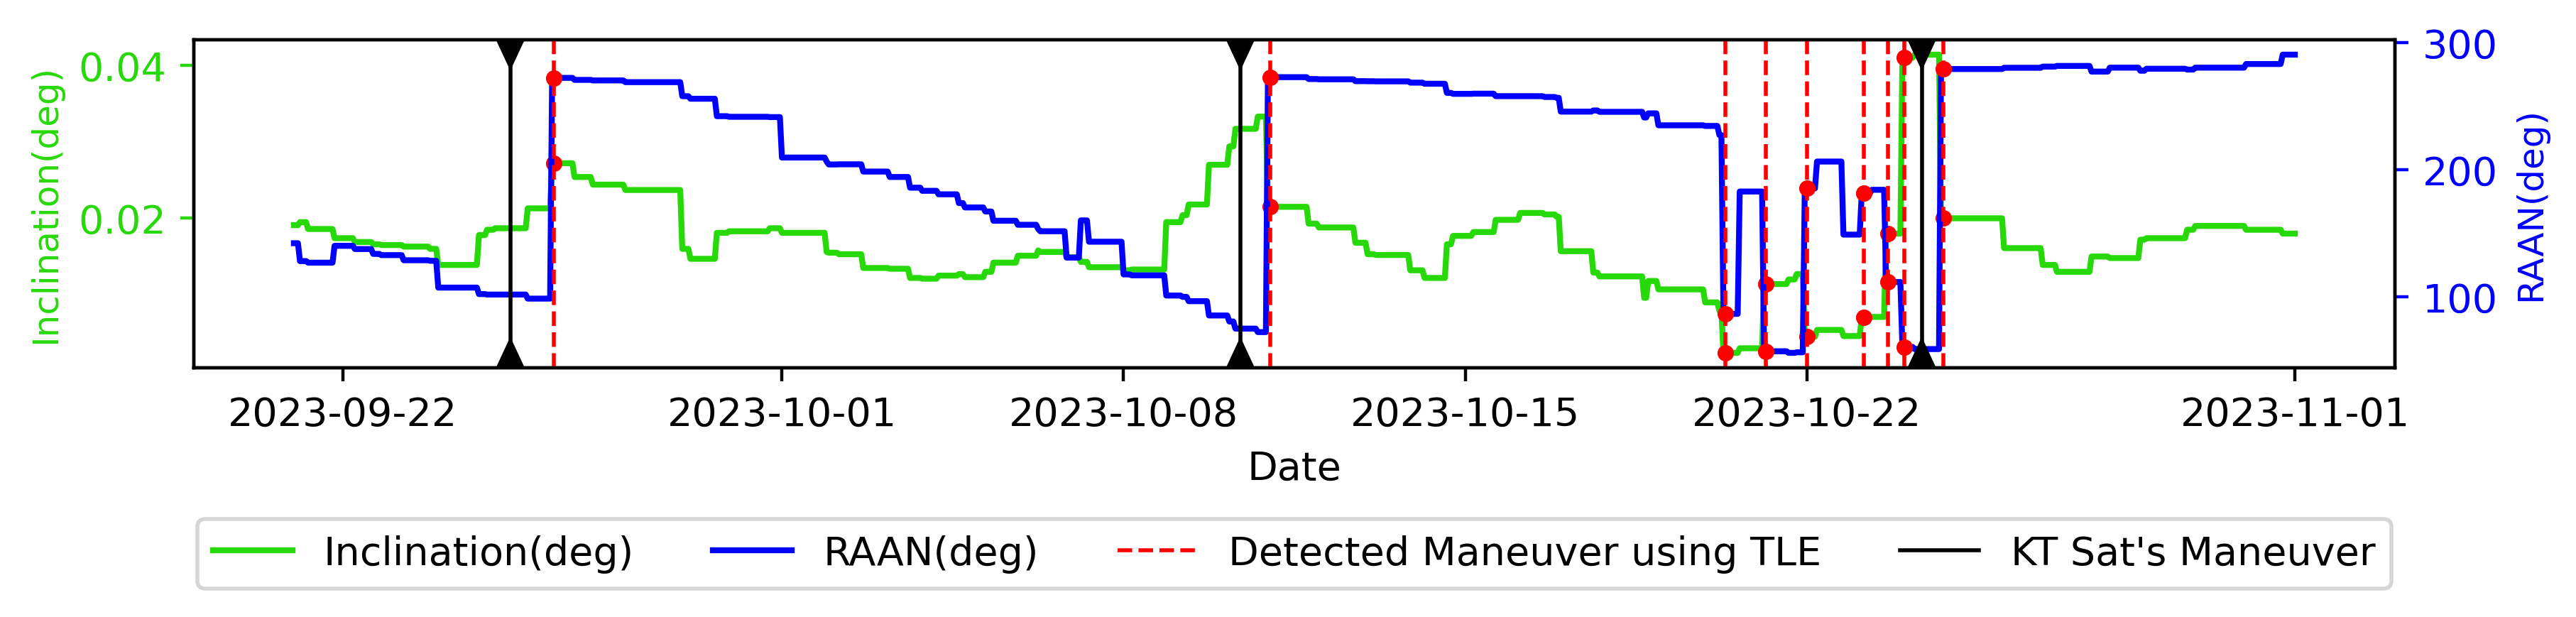

In [8]:
plot_graph(created_hour_df, kt_data_Z, False, '2023-09-21', '2023-11-01')

# Epoch time KT sat Z Manuevering

window : 120, level : 95


100%|██████████| 13753/13753 [00:04<00:00, 3220.67it/s]


window : 240, level : 95


100%|██████████| 13633/13633 [00:04<00:00, 3333.18it/s]


window : 120, level : 99


100%|██████████| 13753/13753 [00:04<00:00, 3000.82it/s]


window : 240, level : 99


100%|██████████| 13633/13633 [00:04<00:00, 2733.02it/s]


window : 120, level : 95


100%|██████████| 13753/13753 [00:04<00:00, 2841.27it/s]


window : 240, level : 95


100%|██████████| 13633/13633 [00:05<00:00, 2306.52it/s]


window : 120, level : 99


100%|██████████| 13753/13753 [00:05<00:00, 2293.06it/s]


window : 240, level : 99


100%|██████████| 13633/13633 [00:05<00:00, 2412.47it/s]


95% threshold, 120hours


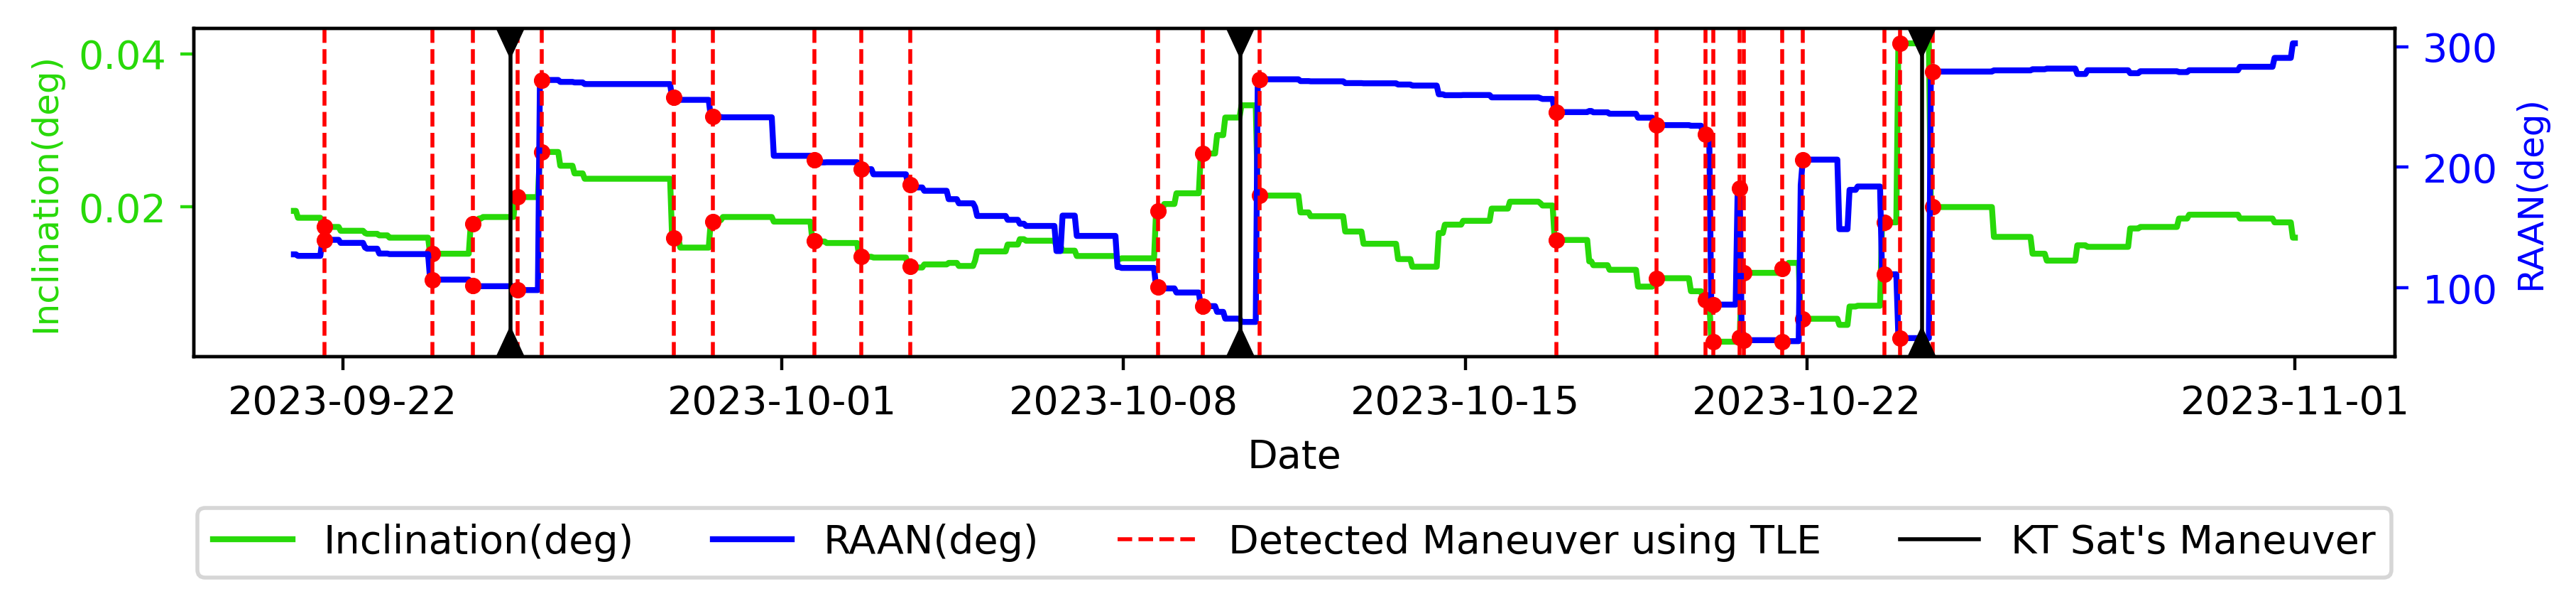

95% threshold, 240hours


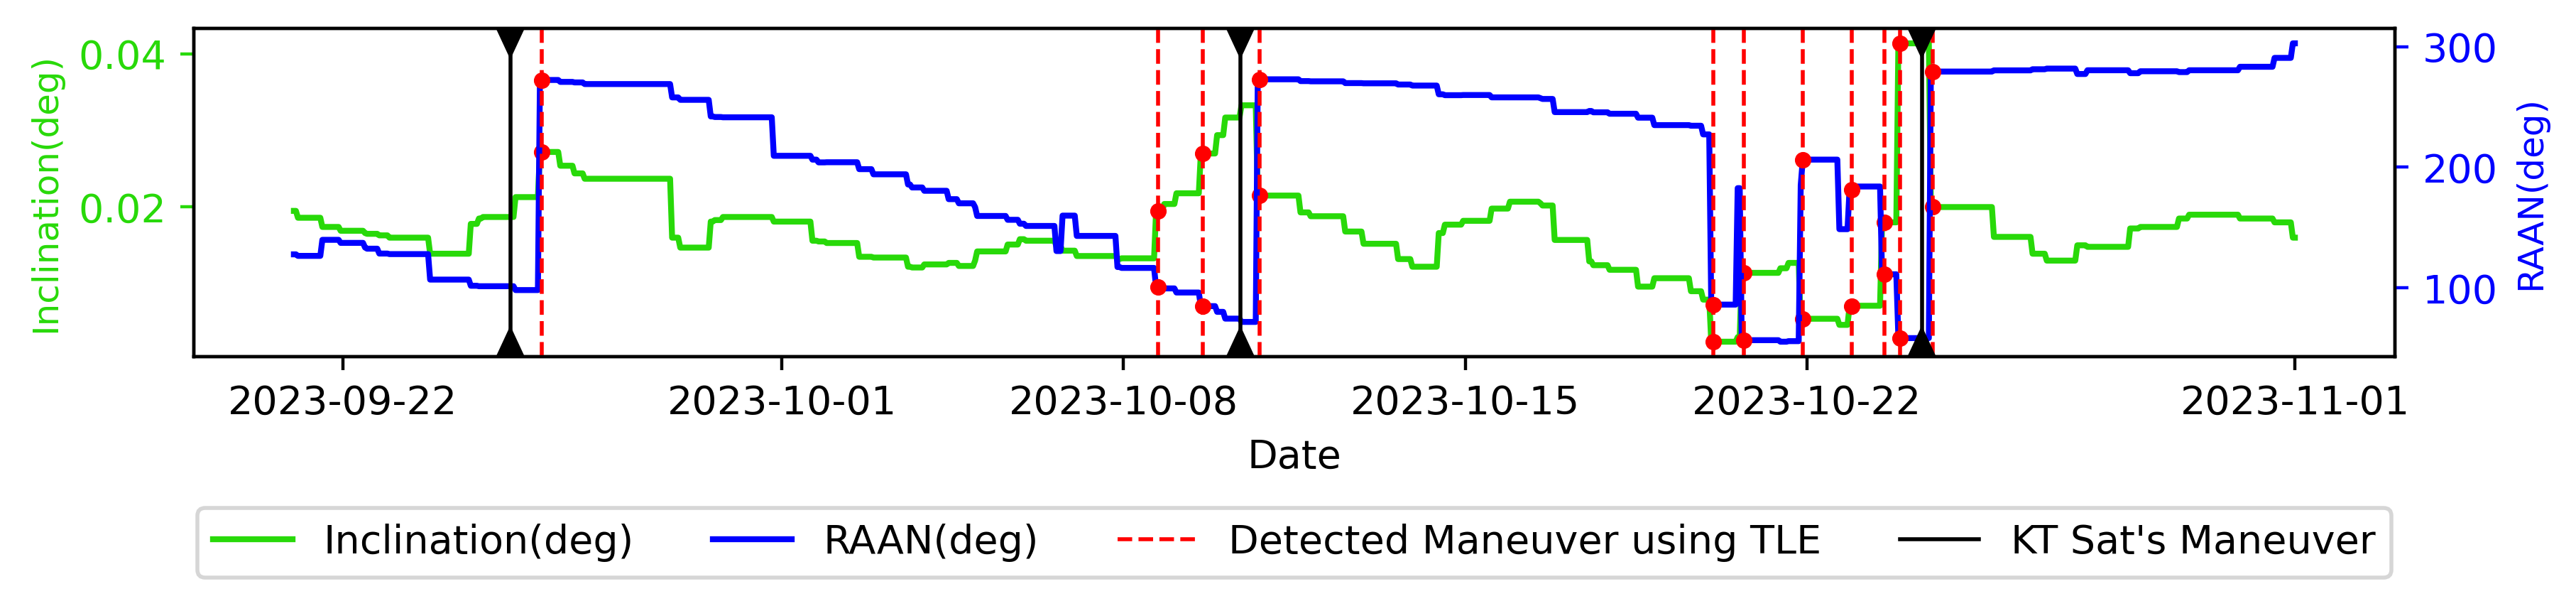

99% threshold, 120hours


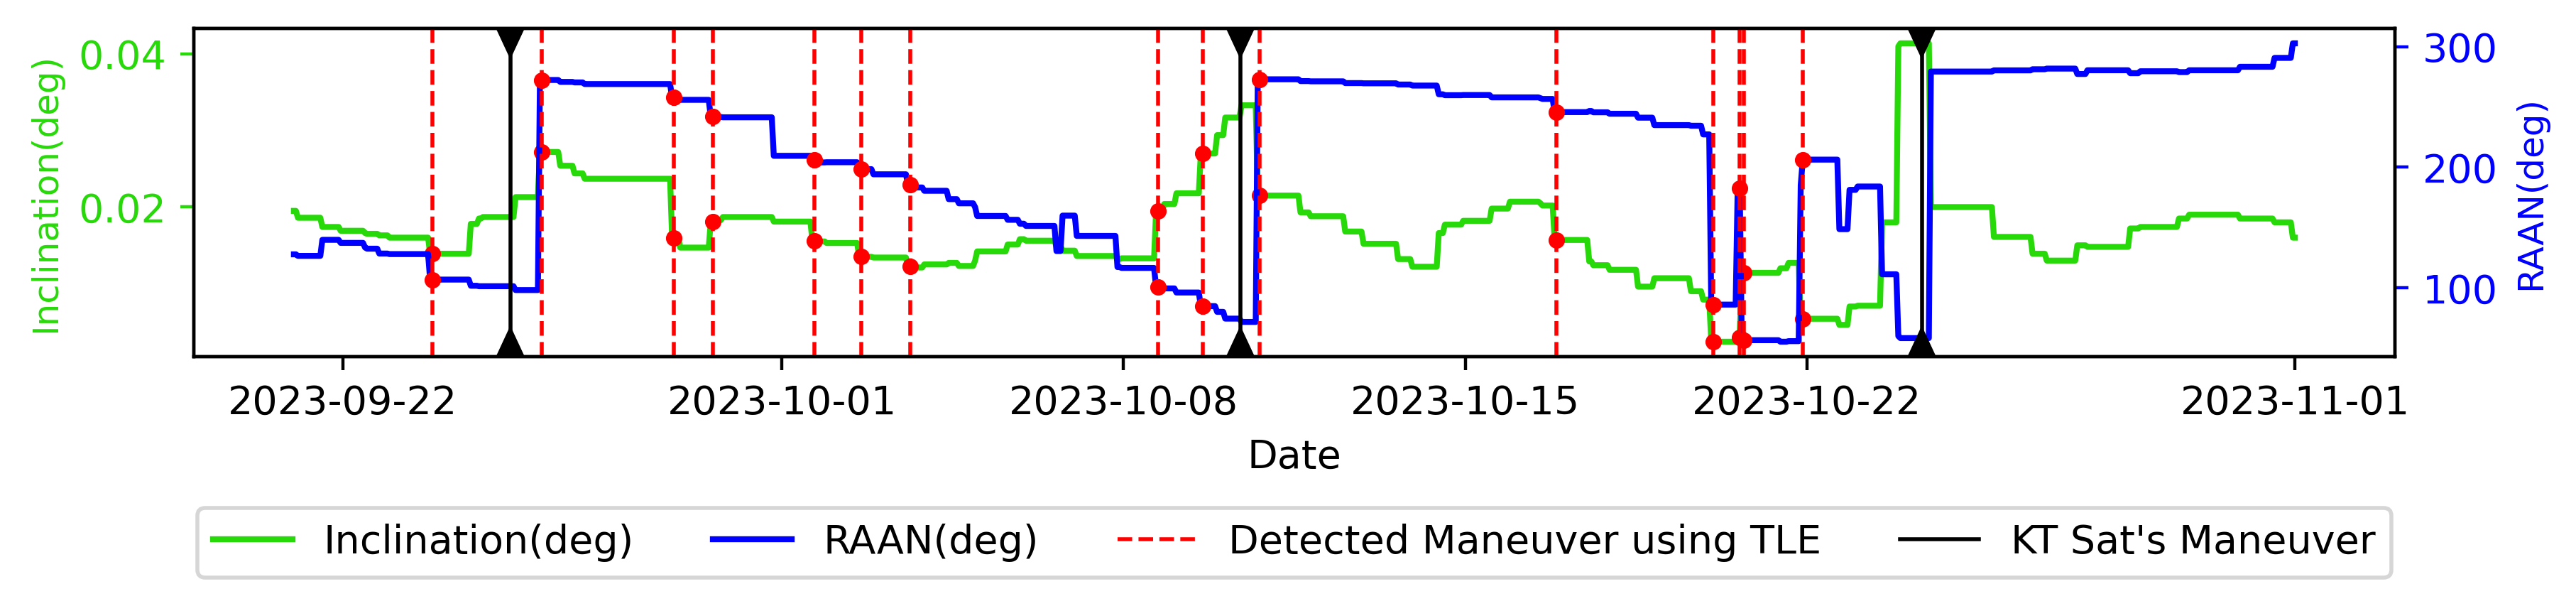

99% threshold, 240hours


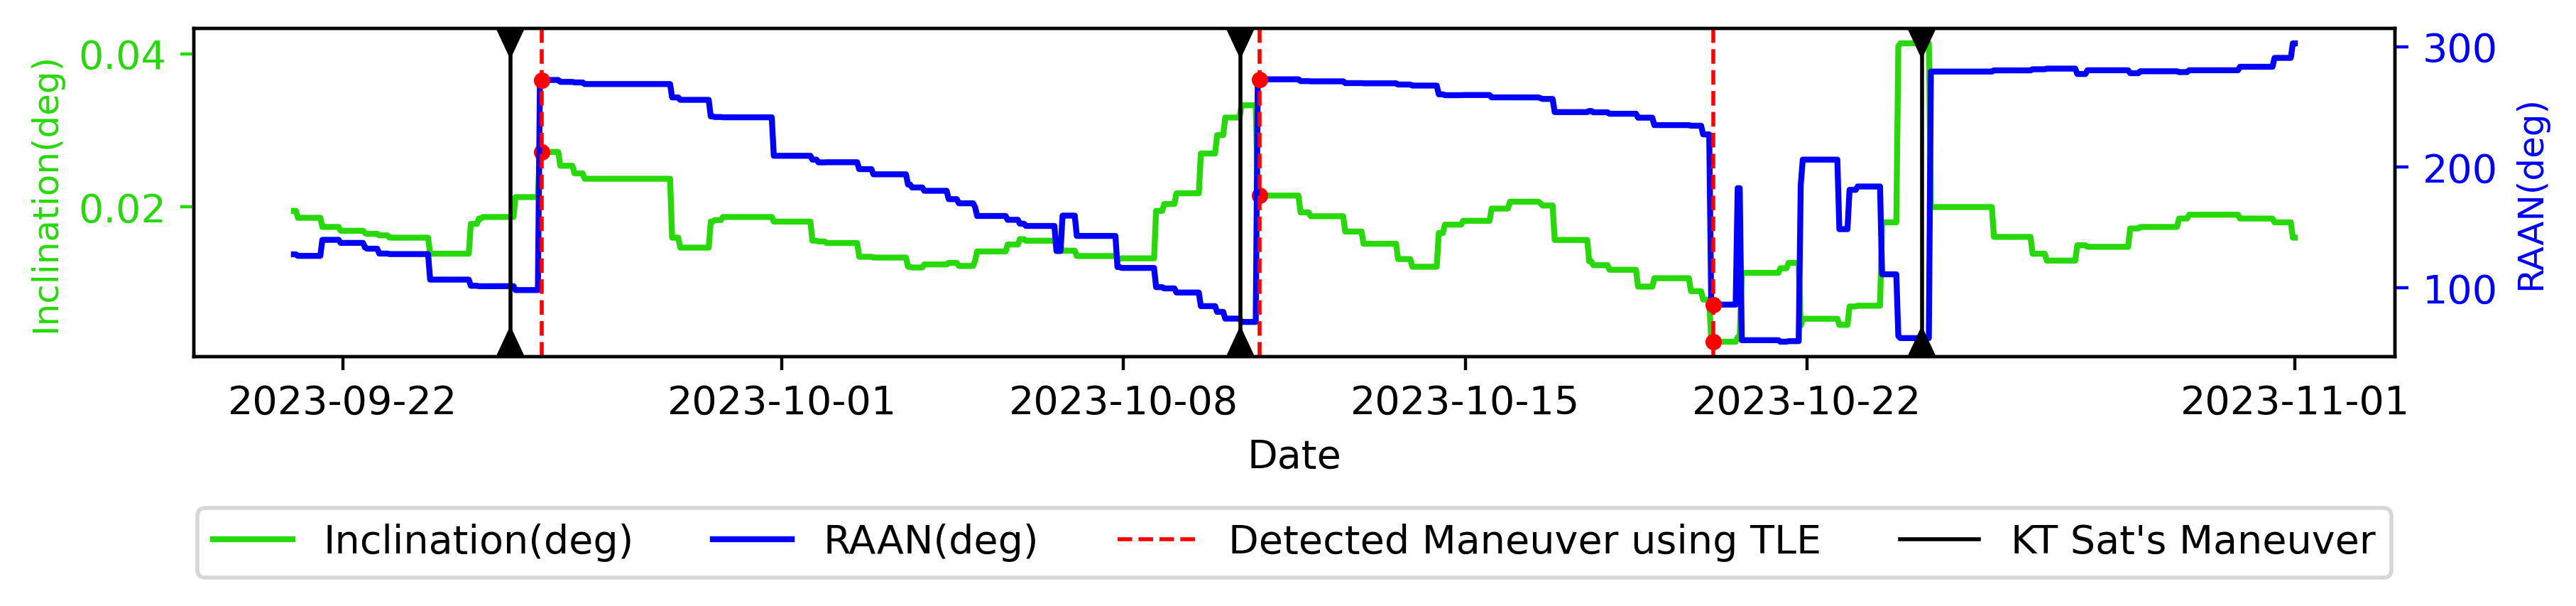

In [9]:
plot_graph(epoch_hour_df, kt_data_Z, False, '2023-09-21', '2023-11-01')